# Data Processing

This notebook is designed to make the test statistics for the associated manuscript openly available, as well as show the data processing workflow. This notebook requires the associated "sum logits.pkl" file for processing.

# Dependencies

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, auc, r2_score, roc_curve, f1_score
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
%matplotlib inline

2024-04-03 20:20:58.807373: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Custom functions

In [2]:
# File containing dictionary of logits and labels
logits_pkl = './sum logits.pkl'

# Loading results
with open(logits_pkl,'rb') as f:
    results = pkl.load(f)

# Model types
mtypes = ['RaSCL','ImageNet']
# Storage list
data = []

# Unpacking and processing data per model type
for k in results['logits'].keys():
    # Processing replicates
    for i in range(len(results['logits'][k])):
        # Taking data for each replicate
        x = results['labels'][i]
        y_predicted = tf.keras.activations.softmax(results['logits'][k][i],axis=-1)
        # Taking column for FTMH-associated classification
        y = np.asarray(y_predicted)[...,1]
        # Fitting receiver operating characteristic curve
        fpr, tpr, _ = roc_curve(y_true=x, y_score=y, pos_label=1, drop_intermediate=False)
        # Taking area under curve for ROC
        auc_score = auc(fpr, tpr)
        # Using default softmax threshold for classification
        correct = (y > 0.5).astype(np.int16)
        # Samples per group
        n_ftmh = np.sum(x == 1)
        n_ctrl = np.sum(x == 0)
        # False negatives
        fn = np.sum((correct != x)[x == 1])
        # False positives
        fp = np.sum((correct != x)[x == 0])
        # True negatives
        tn = np.sum((correct == x)[x == 0])
        # True positives
        tp = np.sum((correct == x)[x == 1])
        # Precision
        precision = tp / (tp + fp)
        # Specificity
        specificity = tn / (tn + fp)
        # Sensitivity/Recall
        sensitivity = tp / (tp + fn)
        # Direct F1 score for FTMH classification
        f1_ftmh = f1_score(x,correct)
        # Inverting target label and scoring for control F1 score
        f1_ctrl = f1_score(1-x,1-correct)

        # Appending dictionary of statistics for each replicate
        data.append({'Model':k,
                     'roc_auc':auc_score,
                     'n FTMH':n_ftmh,
                     'n Control':n_ctrl,
                     'fn':fn,
                     'fp':fp,
                     'tn':tn,
                     'tp':tp,
                     'Precision':precision,
                     'Specificity':specificity,
                     'Sensitivity':sensitivity,
                     'F1 FTMH':f1_ftmh,
                     'F1 Control':f1_ctrl,
                     'fpr':fpr,
                     'tpr':tpr,
                     })
        
# Compiling dataframe from list of dictionaries
df = pd.DataFrame.from_records(data)

2024-04-03 20:21:00.518135: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-03 20:21:00.518173: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cdd6f817b187
2024-04-03 20:21:00.518180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cdd6f817b187
2024-04-03 20:21:00.518294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.147.5
2024-04-03 20:21:00.518310: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.147.5
2024-04-03 20:21:00.518316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.147.5
2024-04-03 20:21:00.519241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instr

# Summary statistics figure

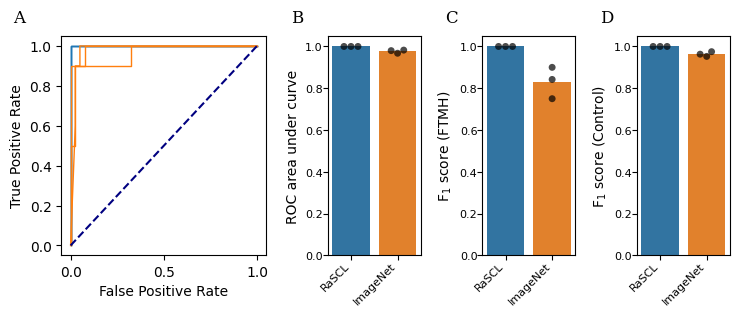

In [3]:
# Items to plot on top of ROC
to_plot = ['roc_auc','F1 FTMH','F1 Control']
# Y labels for each item to plot
ylabs = ['ROC area under curve','F$_1$ score (FTMH)','F$_1$ score (Control)']
# Specifying font size
fsize = 8

# Model values
mvals = df.Model.unique()
# Creating color dictionary for consistent display
cdict = dict(zip(mvals,sns.color_palette()[:len(mvals)]))
df['colors'] = [cdict[i] for i in df.Model]
fig,axs = plt.subplots(nrows=1, ncols=4, 
                       gridspec_kw={'width_ratios':[2.2,1,1,1]},
                      figsize = (7.5,3))


# Plotting ROC curve for each replicate
for i in range(len(df)):
    axs[0].plot(df.fpr[i],
                df.tpr[i],
                lw=1, color = cdict[df.Model[i]],label=df.Model[i]) 
axs[0].plot([0, 1], [0, 1], color="navy", ls="--")
axs[0].set_xlabel("False Positive Rate",fontsize = fsize+2)
axs[0].set_ylabel("True Positive Rate",fontsize = fsize+2)

# Adding subplot for each metric specified
for i in range(len(to_plot)):
    ytype = to_plot[i]
    sns.barplot(ax=axs[i+1],x='Model',y=ytype,data=df,palette=cdict,ci=None)
    sns.swarmplot(ax=axs[i+1],x='Model',y=ytype,data=df, color="0", alpha=.7)
    axs[i+1].set_ylabel(ylabs[i],fontsize = fsize+2)
    axs[i+1].set_xlabel(None)
    axs[i+1].tick_params(pad=0,labelsize = fsize) 
    axs[i+1].set_xticklabels(labels=df.Model.unique(),rotation=45,ha='right',fontsize = fsize)
plt.subplots_adjust(wspace=0.00)
fig.tight_layout(rect=[0, 0.00, 1, 1])
# Adding lettering labels to subplots
for i in range(len(axs)):
    ax = axs[i]
    label = [f'{j}' for j in 'ABCDE'][i]
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,
            fontsize = fsize+4, va='bottom', fontfamily='serif')


# Summary statistics table

Summarizing statistics with a pivot table for precision, specificity, sensitivity, F1 scores, and n per group per replicate, displayed as mean $\pm$ std.

In [4]:
pivot = df.pivot_table(values=['Precision', 'Specificity', 'Sensitivity', 'F1 FTMH', 'F1 Control', 'n FTMH', 'n Control'], 
                       index='Model',
                       aggfunc=['mean','std'])

pivot.groupby([i[1] for i in pivot.columns], axis=1).apply(lambda x: round(x,3).astype(str).apply(' ± '.join, 1))

,F1 Control,F1 FTMH,Precision,Sensitivity,Specificity,n Control,n FTMH
Model,,,,,,,
ImageNet,0.963 ± 0.011,0.831 ± 0.076,0.93 ± 0.061,0.767 ± 0.153,0.983 ± 0.014,40 ± 0,10 ± 0
RaSCL,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,40 ± 0,10 ± 0


# T-test statistic for ROC AUC comparison

In [5]:
scipy.stats.ttest_ind(df['roc_auc'].values[df.Model=='RaSCL'],
                      df['roc_auc'].values[df.Model=='ImageNet'])

/tmp/ipykernel_585705/1024708713.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.ttest_ind(df['roc_auc'].values[df.Model=='RaSCL'],


Ttest_indResult(statistic=5.028948456749707, pvalue=0.007338923840570511)

# T-test statistic for F1 score comparison (FTMH classification)

In [6]:
scipy.stats.ttest_ind(df['F1 FTMH'].values[df.Model=='RaSCL'],
                      df['F1 FTMH'].values[df.Model=='ImageNet'])

/tmp/ipykernel_585705/3934108978.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.ttest_ind(df['F1 FTMH'].values[df.Model=='RaSCL'],


Ttest_indResult(statistic=3.87631485584411, pvalue=0.017897187106606864)